# TSI Classifier, custom model

This document is an instruction in how to build a custom convolutional neural network using Keras, how to train it, evaluate it and use it to make predictions. The document has the following sections:

* Importing packages
* Import dataset
* Creating model 
* Train model
* Test model on test set
* Predict on single image
* Predict on large raw datasets

## Importing packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix

from predict_functions import MassPredictor, FilterPredictions, ExportFilteredFiles, TrainingProgress, PredictImage, ShowPrediction

## Import dataset

In [2]:
def LoadTrainAndValData(data_path, batch_size=32 ,img_height=352,img_width=288,num_classes=3,seed=111):
    data_dir = pathlib.Path(data_path) 

    train_datagen = ImageDataGenerator( # Choose how to augment the training data. Too much augmentation reduces performance,
        brightness_range = (0.5, 1.5),  # too little augmentation might lead to quicker overfitting 
        horizontal_flip=True,
        vertical_flip=True,
    #    rotation_range = 360,           # Rotation might be too heavy augmentation and should probably be used together with
    #    zoom_range=[1.10, 1.10],        # zoom (out) to avoid cropping out the important parts of the image
        validation_split=0.2)           # Ratio of dataset which is reserved for validation (not trained on)

    val_datagen = ImageDataGenerator(   # Validation data should not be augmented
        validation_split=0.2)           # Ratio of dataset which is reserved for validation (not trained on)

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        shuffle = True,                 # It is important to shuffle training data
        seed = seed,                    # Seed should be the same on the two generators to make sure that validation and
        batch_size=batch_size,          # training datasets does not get mixed up
        class_mode='categorical',
        subset = 'training')

    validation_generator = val_datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        shuffle = True,
        seed = seed,
        batch_size=batch_size,
        class_mode='categorical',
        subset = 'validation')
    return train_generator, validation_generator

In [3]:
data_path = 'data/training'
batch_size = 32
img_height = 352
img_width = 288
num_classes = 3    # Number of classes, e.g. 'fogbow/iceoptics/no_optics'
seed = 3131

train_generator, validation_generator = LoadTrainAndValData(data_path, batch_size, img_height, img_width, num_classes, seed)

Found 176 images belonging to 3 classes.
Found 42 images belonging to 3 classes.


### Visualising augmentation

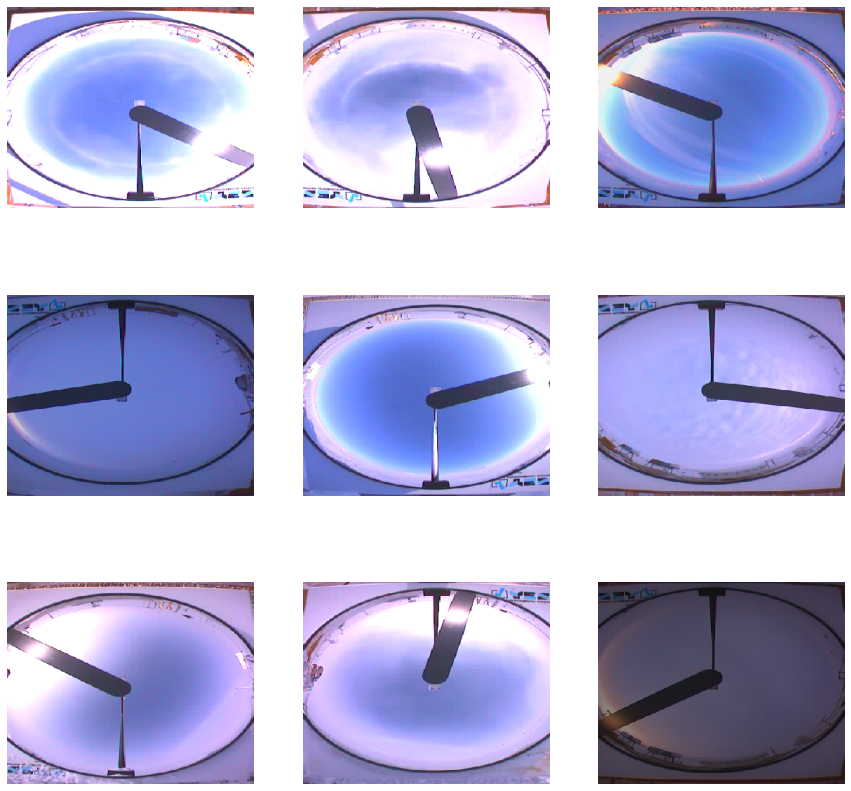

In [4]:
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = next(train_generator)[0][0].astype('uint8')
    ax.imshow(image)
    ax.axis('off')

## Creating model

Here I present two different models, one with heavy use of dropout and one with batch normalization. I will not go into details about the differences and similarities nor recommend any, it only serves as an example. At the time of this writing I haven't done any thorough testing of any of their performances but if I have time I'll try them out and present the results on the GitHub README. 

In [5]:
# Dropout model
# https://www.tensorflow.org/tutorials/images/classification

def get_compiled_model_dropout():
    model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),  # Rescales the pixel values from 0-255 to 0-1 (recommended)
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')   # Layer size must equal the number of classes!
    ])
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[keras.metrics.CategoricalAccuracy()])
    return model

In [6]:
# Batchnorm model
# https://www.machinecurve.com/index.php/2020/01/15/how-to-use-batch-normalization-with-keras/f

def get_compiled_model_batch():
    model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255), # Rescales the pixel values from 0-255 to 0-1 (recommended)
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax') # Layer size must equal the number of classes!
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), # sets the learning rate manually
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[keras.metrics.CategoricalAccuracy()])
    return model

In [8]:
model = get_compiled_model_dropout()

In [7]:
model = get_compiled_model_batch()

In [9]:
model.build((None,288,352,3))
model.summary() # Visualises the model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 288, 352, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 288, 352, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 144, 176, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 144, 176, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 144, 176, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 72, 88, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 88, 32)       

## Train model

In [10]:
epochs = 5
checkpoint_path = "checkpoints/classifier/classifier_{epoch}.h5"
batch_size = 32

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples // batch_size,
  epochs=epochs,
  validation_data=validation_generator,
  validation_steps=validation_generator.samples // batch_size,
  callbacks = [checkpoint]
)

Epoch 1/5
5/5 [==============================] - 9s 1s/step - loss: 20.2589 - categorical_accuracy: 0.3472 - val_loss: 3.6360 - val_categorical_accuracy: 0.4375

Epoch 00001: val_categorical_accuracy improved from -inf to 0.43750, saving model to checkpoints/classifier/classifier_1.h5
Epoch 2/5
5/5 [==============================] - 7s 1s/step - loss: 4.5320 - categorical_accuracy: 0.3611 - val_loss: 1.1258 - val_categorical_accuracy: 0.2500

Epoch 00002: val_categorical_accuracy did not improve from 0.43750
Epoch 3/5
5/5 [==============================] - 7s 1s/step - loss: 1.2310 - categorical_accuracy: 0.3333 - val_loss: 1.0940 - val_categorical_accuracy: 0.4062

Epoch 00003: val_categorical_accuracy did not improve from 0.43750
Epoch 4/5
5/5 [==============================] - 7s 1s/step - loss: 1.1092 - categorical_accuracy: 0.4236 - val_loss: 1.0920 - val_categorical_accuracy: 0.4062

Epoch 00004: val_categorical_accuracy did not improve from 0.43750
Epoch 5/5
5/5 [===============

### Visualise training progress

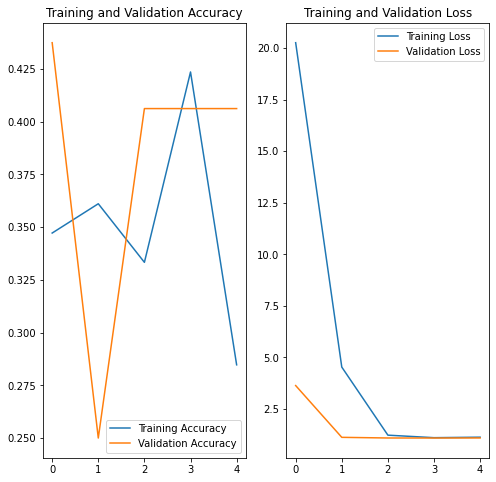

In [11]:
TrainingProgress(history, epochs,'lossgraph/classifier_1.png')

### Save model

Now you'd probably like to save your model, including weights:

In [12]:
model.save('saved_model/classifier_1')

INFO:tensorflow:Assets written to: saved_model/classifier_1/assets


To load a model again, run:

In [2]:
#model = tf.keras.models.load_model('saved_model/finetune') 

## Test model on test set

In [13]:
data_dir = 'tsi_realtest'
img_width = 288
img_height = 352
batch_size = 32

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        shuffle = False,
        batch_size=batch_size,
        class_mode='categorical')

Found 6967 images belonging to 3 classes.


For detailed classification report:

In [14]:
batch_size = 32
Y_pred = model.predict(test_generator, test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = ['Fogbow', 'Iceoptics', 'No optics']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Fogbow       0.00      0.00      0.00       305
   Iceoptics       0.00      0.00      0.00       870
   No optics       0.83      1.00      0.91      5792

    accuracy                           0.83      6967
   macro avg       0.28      0.33      0.30      6967
weighted avg       0.69      0.83      0.75      6967



/opt/tljh/user/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Otherwise a simpler, general evaluation of the model can be found by running

In [15]:
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
218/218 [==============================] - 55s 249ms/step - loss: 1.0806 - categorical_accuracy: 0.8313
test loss, test acc: [1.080627202987671, 0.8313477635383606]


## Predict on single image

This image most likely belongs to 
 no_optics with a 33.59 % confidence.


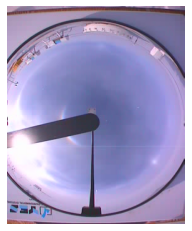

In [16]:
predic_dir = 'data/examples'
path = os.path.join(predic_dir, os.listdir(predic_dir)[1])
prediction=PredictImage(path, model)
ShowPrediction(path, prediction,train_generator.class_indices)

## Predict on large datasamples

See discription in transfer.ipynb

In [ ]:
# All following paths should already exist before running commands

tar_files_path = "data/to_be_predicted" # path to input tar files for prediction
predictions_CSV_path = "predictions/predictions_CSV" # path where the output CSV files will be placed
predicted_path = 'predictions/predicted_files' # path where the images will be copied to in labeled folder structure

In [ ]:
MassPredictor(tar_files_path, predictions_CSV_path, model) 

In [ ]:
fog, ice, no = FilterPredictions(predictions_CSV_path,0.3)

In [ ]:
ExportFilteredFiles(tar_files_path, predicted_path, fog, ice, no)

End of document